In [1]:
# Written By : Jonathan O. Tellechea
# Adviser    : Mike Hance, Phd
# Research   : Using a neural network to maximize the significance of tttHH production.
# Reference  :http://cdsweb.cern.ch/record/2220969/files/ATL-PHYS-PUB-2016-023.pdf
###########################################################################################################################
import numpy as np
import pandas as pd
import uproot
import tensorflow as tf
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
%matplotlib inline  
import mpld3
mpld3.enable_notebook()
###########################################################################################################################
# Variables.
seed = 42
tree = 'OutputTree'
# branches = ['numjet','numlep','btag','srap','m_bb']
# numofbranches = len(branches)
###########################################################################################################################
# Branches names of high/low level variables aka: features. 
# branches = ['numjet','numlep']
# branches = ['numlep','numjet','lep1pT','lep1eta','lep1phi','lep1m','lep2pT','lep2eta','lep2phi','lep2m','lep3pT',
#             'lep3eta','lep3phi','lep3m','mt1','mt2','mt3','dr1','dr2','dr3','btag','cent','srap','m_bb','h_b']
# branches = ['numlep','numjet','lep1pT','lep1eta','lep1phi','lep1m','lep2pT','lep2eta','lep2phi','lep2m','lep3pT',
# 'lep3eta','lep3phi','lep3m']
# branches = ['numjet','numlep','btag','srap','cent','m_bb','h_b','mt1','mt2','mt3']
branches = ['numjet','numlep','btag','srap','cent','m_bb','h_b','mt1','mt2','mt3','dr1','dr2','dr3']
numofbranches = len(branches)
###########################################################################################################################
# Data read from file.

signal         = uproot.open('new_signal_tthh.root')[tree]
df_signal      = signal.pandas.df(branches)
background     = uproot.open('background.root')[tree]
df_background  = background.pandas.df(branches)
alldata        = uproot.open('full.root')[tree]
df_alldata     = alldata.pandas.df(branches) 
# shuffles background.

shuffleBackground = shuffle(df_background,random_state=seed)
# signal and limited shuffle background data to counter inbalanced data problem.

X = pd.concat([df_signal,shuffleBackground[0:5709]])
X = sc.fit_transform(X)

# Labeling data with 1's and 0's to distinguish. 
y = np.concatenate((np.ones(len(signal)), np.zeros(len(shuffleBackground[0:5709]))))

# Shuffle full data and split into train/test and validation set.
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size = 0.1, random_state=seed)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size = 0.1,random_state=seed)

Using TensorFlow backend.


In [2]:
# NN model defined as a function.
def build_model():
    model = Sequential()
    model.add(Dense(10, input_dim=numofbranches, activation='relu'))
    model.add(Dense(10 , activation='relu')) #hidden layer
    model.add(Dense(1 ,activation='sigmoid'))#output layer
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return  model
def plotROC(x,y,ROC):
    plt.plot(x,y, lw=1, label='ROC (area = %0.6f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.grid()
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


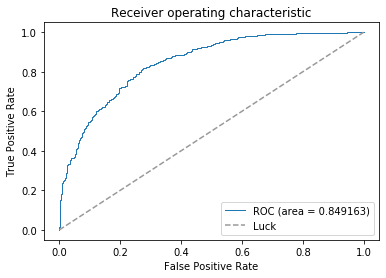

In [3]:
# Using model and setting parameters. 
keras_model = build_model()
history = keras_model.fit(X_train, y_train,epochs=50, batch_size=570,validation_data=(X_dev, y_dev), verbose=0)

# Prediction, fpr,tpr and threshold values for ROC.
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

# AUC
roc_auc = auc(fpr_keras, tpr_keras)
plotROC(fpr_keras, tpr_keras,roc_auc)

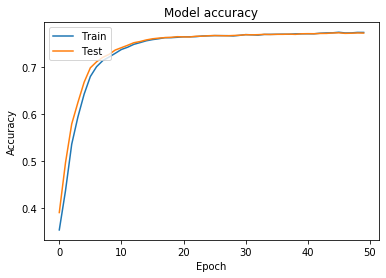

In [4]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

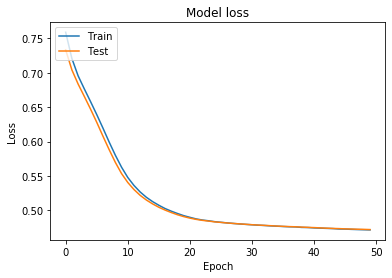

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()